In [8]:
import numpy as np
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick

In [9]:
dev = "cpu"

In [10]:
def rotation_grid(arr, theta, dev):

    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta), 0.0], device=dev)
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta), 0.0], device=dev)
    m = tc.stack([m0, m1]).view(1, 2, 3)
    m = m.repeat([arr.shape[0], 1, 1]) 
    g = F.affine_grid(m, arr.shape)
    
    return g

def rotate(arr, theta, dev):
    
    g = rotation_grid(arr, theta, dev)
    q = F.grid_sample(arr, g, padding_mode='border')
    
    return q

In [11]:
def get_cooridnates_stack_for_rotation(array_size, axis=0):
    """
    Get the coordinates of the grid points
    
    Parameters
    ----------     
    array_size: list
        object dimension in [N, H, W]
        
    Returns
    -------
    coord_new: numpy array
        The coordinates of the grid points with the dimensions [2, # of grid points]. 
        The first dimension is 2 because there're x and y coodinates for each grid point.
    
    """
    image_center = [(x - 1) / 2 for x in array_size]
    coords_ls = []
    for this_axis, s in enumerate(array_size):
        if this_axis != axis:
            coord = np.arange(s)
            for i in range(len(array_size)):
                if i != axis and i != this_axis:
                    other_axis = i
                    break
            if other_axis < this_axis:
                coord = np.tile(coord, array_size[other_axis])
            else:
                coord = np.repeat(coord, array_size[other_axis])
            coords_ls.append(coord - image_center[i])
    coord_new = np.stack(coords_ls)
    return coord_new

def calculate_original_coordinates_for_rotation(array_size, coord_new, theta, dev=None):
    """
    Calculate the old coordinates (coodinates without rotation) of the current grid points before rotation by rotating the current grid points back.
    
    Parameters
    ----------
    array_size: list
        object dimension in [N, H, W]

    cood_new: numpy array
        Use the return output from the get_cooridnates_stack_for_rotation function.

    theta: float
    
    Returns
    -------
    coord_old: torch tensor
        the old coordinates (before rotation) of the current grid points
        the dimension = [# of grid points, 2]
    """
    image_center = [(x - 1) / 2 for x in array_size]
    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta)], device=dev)
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta)], device=dev)
    m_rot = tc.stack([m0, m1])

    coord_old = tc.matmul(m_rot, coord_new)
    coord1_old = coord_old[0, :] + image_center[1]
    coord2_old = coord_old[1, :] + image_center[2]
    coord_old = np.stack([coord1_old, coord2_old], axis=1)
    return coord_old

def save_rotation_lookup(array_size, theta_ls, dest_folder=None):
    """
    Save the old coordinates (before rotating theta) of the current grid points for all object angles in theta_ls.
    Save the old coordinates (before rotating -theta) of the current grid points for all object angles in theta_ls.
    
    Parameters
    ----------
    array_size: list
        object dimension in [N, H, W]
        
    theta_ls: torch tensor
        a torch tensor of all obeject angles
        
    dest_folder: string
        the path of storing the old coordinates
    
    Returns
    -------
    None
        
    """

    # create matrix of coordinates
    coord_new = tc.from_numpy(get_cooridnates_stack_for_rotation(array_size, axis=0).astype(np.float32))

    n_theta = len(theta_ls)
    if dest_folder is None:
        dest_folder = 'arrsize_{}_{}_{}_ntheta_{}'.format(array_size[0], array_size[1], array_size[2], n_theta)
    if not os.path.exists(dest_folder):
        os.mkdir(dest_folder)
    for i, theta in enumerate(theta_ls):  #changed from theta_ls[rank:n_theta:n_ranks]
        coord_old = calculate_original_coordinates_for_rotation(array_size, coord_new, theta)
        coord_inv = calculate_original_coordinates_for_rotation(array_size, coord_new, -theta)
        # coord_old_ls are the coordinates in original (0-deg) object frame at each angle, corresponding to each
        # voxel in the object at that angle.
        np.save(os.path.join(dest_folder, '{:.5f}'.format(theta)), coord_old.astype('float16'))
        np.save(os.path.join(dest_folder, '_{:.5f}'.format(theta)), coord_inv.astype('float16'))
    return None

def read_origin_coords(src_folder, theta, reverse=False):
    """
    Read the old coordinates from the file generated from the save_rotation_lookup function
    
    Parameters
    ----------
    src_folder: string
        saving path of the old coordinates
    
    theta: float
        object angle
    
    reverse: Boolean
        If the rotating angle is theta, set reverse to True.
    """
    if not reverse:
        coords = np.load(os.path.join(src_folder, '{:.5f}.npy'.format(theta)), allow_pickle=True)
    else:
        coords = np.load(os.path.join(src_folder, '_{:.5f}.npy'.format(theta)), allow_pickle=True)
    return tc.from_numpy(coords).type(tc.float)

## initialize parameters

In [12]:
def init_xp(xp, theta, recon_path, dev):
    
    def apply_rotation_transpose_to_grad(obj, interpolation='bilinear', axis=0, device=None):
        """
        Apply the transpose of the rotation matrix to the obj matrix.

        Parameters
        ----------
        obj: torch tensor
            obj is the tensor which the rotation transpose matrix is going to act on.
            The dimension = [C, N, H, W]

        Returns
        -------
        coord_old: torch tensor
            the old coordinates (before rotation) of the current grid points
            the dimension = [# of grid points, 2]

        interpolation: string
            the interpolation method to get the values in the new grid

        axis: integer
            the axis which the obj rotates about

        Returns
        -------
        obj_rot: torch tensor
            the torch tensor after applying the rotation transpose
            the dimension = [C, N, H, W]

        """
        coord_old = read_origin_coords(os.path.join(recon_path, "rotation_look_up"), theta).to(dev)
        # The dimension of the input obj is [C, N, H, W]
        # This piece of code is borowed from Ming. He arranged the object in [N, H, W, C]

        obj = obj.permute(1,2,3,0)
        s = obj.shape
        axes_rot = []
        for i in range(len(obj.shape)):
            if i != axis and i <= 2:
                axes_rot.append(i)

        coord_old_1 = coord_old[:, 0]
        coord_old_2 = coord_old[:, 1]

        # Clip coords, so that edge values are used for out-of-array indices
        coord_old_1 = tc.clamp(coord_old_1, 0, s[axes_rot[0]] - 1)
        coord_old_2 = tc.clamp(coord_old_2, 0, s[axes_rot[1]] - 1)

        coord_old_floor_1 = tc.floor(coord_old_1).type(tc.int64)
        coord_old_ceil_1 = coord_old_floor_1 + 1
        coord_old_floor_2 = tc.floor(coord_old_2).type(tc.int64)
        coord_old_ceil_2 = coord_old_floor_2 + 1
        # create an empty object to store the results after applying the rotation transpose
        obj_rot = tc.zeros_like(obj, requires_grad=False)

        # calculate the area fraction
        # the dimension of fac_XX = [H * W]
        fac_ff = (coord_old_ceil_1 - coord_old_1) * (coord_old_ceil_2 - coord_old_2)
        fac_fc = (coord_old_ceil_1 - coord_old_1) * (coord_old_2 - coord_old_floor_2)
        fac_cf = (coord_old_1 - coord_old_floor_1) * (coord_old_ceil_2 - coord_old_2)
        fac_cc = (coord_old_1 - coord_old_floor_1) * (coord_old_2 - coord_old_floor_2)

        # expand fac_XX along the dimension C, the dimension = [H * W, C]
        fac_ff = tc.stack([fac_ff] * s[-1], axis=1)
        fac_fc = tc.stack([fac_fc] * s[-1], axis=1)
        fac_cf = tc.stack([fac_cf] * s[-1], axis=1)
        fac_cc = tc.stack([fac_cc] * s[-1], axis=1)

        # apply the rotation transpose to each layer (along dimension N)
        for i_slice in range(s[axis]):

            # slicer_XX represents the indices of the corner points around each points of coord_old.
            # XX = ff, fc, cf, cc represent 4 corners respectively
            # slicer_XX -> [i_slice, tc.tensor([x1, x2, x3, ...]), tc.tensor([y1, y2, y3, ...])]
            slicer_ff = [i_slice, i_slice, i_slice]
            slicer_ff[axes_rot[0]] = coord_old_floor_1
            slicer_ff[axes_rot[1]] = coord_old_floor_2

            slicer_fc = [i_slice, i_slice, i_slice]
            slicer_fc[axes_rot[0]] = coord_old_floor_1
            slicer_fc[axes_rot[1]] = tc.clamp(coord_old_ceil_2, 0, s[axes_rot[1]] - 1)

            slicer_cf = [i_slice, i_slice, i_slice]
            slicer_cf[axes_rot[0]] = tc.clamp(coord_old_ceil_1, 0, s[axes_rot[0]] - 1)
            slicer_cf[axes_rot[1]] = coord_old_floor_2

            slicer_cc = [i_slice, i_slice, i_slice]
            slicer_cc[axes_rot[0]] = tc.clamp(coord_old_ceil_1, 0, s[axes_rot[0]] - 1)
            slicer_cc[axes_rot[1]] = tc.clamp(coord_old_ceil_2, 0, s[axes_rot[1]] - 1)

            # slicer_obj is the index that retrieves a single layer in dimension N
            slicer_obj = [slice(None), slice(None), slice(None)]
            slicer_obj[axis] = i_slice

            # use slicer_obj to retrieve a single layer from obj
            # obj[slicer_obj], dimension = [H, W, C]
            # obj_slice, dimension = [H * W, C]
            obj_slice = tc.reshape(obj[slicer_obj], [-1, s[-1]])
            # tuple(slicer_XX) retrieves the corner points
            obj_rot[tuple(slicer_ff)] += obj_slice * fac_ff
            obj_rot[tuple(slicer_fc)] += obj_slice * fac_fc
            obj_rot[tuple(slicer_cf)] += obj_slice * fac_cf
            obj_rot[tuple(slicer_cc)] += obj_slice * fac_cc

        obj_rot = obj_rot.permute(3,0,1,2)
        return obj_rot
    
    xp = xp[None,None,:,:]
    xp = rotate(xp, theta, dev)
    xp.requires_grad_(True)
    xp.register_hook(apply_rotation_transpose_to_grad)
    
    return xp

In [ ]:
# The Adam optimizer object has the property: params_list =['m', 'v']
class AdamOptimizer(object):
    def __init__(self, ip, name = "adam", params_list=(), output_folder='.'):
        self.ip = ip
        self.name = name
        self.params_list = params_list
        self.output_folder = output_folder
        self.params_chunk_array_dict = {}
        
    def save_params_to_checkpoint(self):
        path = os.path.join(self.output_folder, 'checkpoint')
        if not os.path.exists(path):
            os.makedirs(path)
        if len(self.params_list) > 0:
            arr = []
            for i, param_name in enumerate(self.params_list):
                arr.append(self.params_chunk_array_dict[param_name])
            arr = tc.stack(arr)
            np.save(os.path.join(path, 'opt_{}_params_checkpoint_minibatch_{}.npy'.format(self.name, self.ip)), arr.detach().cpu().numpy())  #self.ip can be replaced by rank in mpi mode
        return None
    
    
    def restore_distributed_param_arrays_from_checkpoint(self, device=None, use_numpy=False, dtype='float32'):
        if len(self.params_list) > 0:
            path = os.path.join(self.output_folder, 'checkpoint', 'opt_{}_params_checkpoint_rank_{}.npy'.format(self.name, self.ip))
            if os.path.exists(path):
                arr = np.load(path)
                arr = tc.from_numpy(arr).float().to(dev)
                if len(self.params_list) > 0:
                    for i, param_name in enumerate(self.params_list):
                        self.params_chunk_array_dict[param_name] = arr[i]
        return None
    
    def apply_gradient(self, g, xp):
        # use g to calculate m and v 
        
        # update xp using m and v
        
        # store the calculated m and v to self.params_chunk_array_dict
        m = self.params_chunk_array_dict['m']
        v = self.params_chunk_array_dict['v']
        
        return xp 

In [13]:
theta = tc.tensor(np.pi/4)

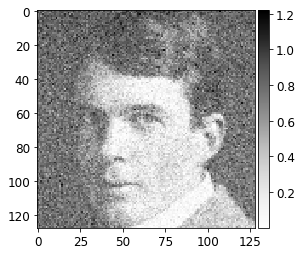

In [41]:
size = 128
# xp = tc.zeros(size, size)
# xp[size//4, size//4] = 0.5
# plt.imshow(xp)

shape = (128, 128)
xp = cv2.imread('photo_gallery/wl-bragg-crop.png', cv2.IMREAD_GRAYSCALE)
xp = cv2.resize(xp, shape)  # Reshape the image
xp = 1 - xp/np.max(xp)   # Invert the image

xp_o = tc.from_numpy(xp).type(tc.float)
xp_on = xp_o + tc.normal(0, 0.1, xp.shape)

fig1 = plt.figure()
gs1 = gridspec.GridSpec(nrows=1, ncols=1)
fig1_ax0 = fig1.add_subplot(gs1[0,0])
pos = fig1_ax0.imshow(np.abs(xp_on), cmap='Greys', origin='upper')
divider = make_axes_locatable(fig1_ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig1.colorbar(pos, cax=cax)

/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


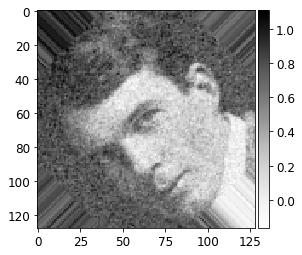

In [42]:
recon_path = "./data/test_rotation_transpose"
xp = init_xp(xp_on, theta, recon_path, dev)

fig1 = plt.figure()
gs1 = gridspec.GridSpec(nrows=1, ncols=1)
fig1_ax0 = fig1.add_subplot(gs1[0,0])
pos = fig1_ax0.imshow(xp.detach()[0,0,:,:], cmap='Greys', origin='upper')
divider = make_axes_locatable(fig1_ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig1.colorbar(pos, cax=cax)

## initialize data (y_hat)

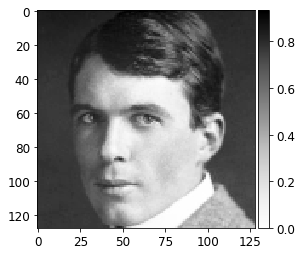

In [43]:
y_hat = tc.clone(xp_o.detach())
y_hat = y_hat[None, None, :,:]

fig1 = plt.figure()
gs1 = gridspec.GridSpec(nrows=1, ncols=1)
fig1_ax0 = fig1.add_subplot(gs1[0,0])
pos = fig1_ax0.imshow(y_hat[0,0,:,:], cmap='Greys', origin='upper')
divider = make_axes_locatable(fig1_ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig1.colorbar(pos, cax=cax)

/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


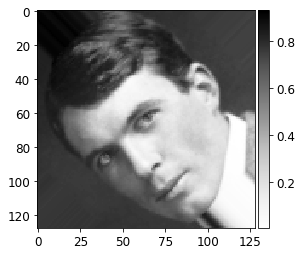

In [44]:
y_hat = rotate(y_hat, theta, dev)
fig1 = plt.figure()
gs1 = gridspec.GridSpec(nrows=1, ncols=1)
fig1_ax0 = fig1.add_subplot(gs1[0,0])
pos = fig1_ax0.imshow(y_hat[0,0,:,:], cmap='Greys', origin='upper')
divider = make_axes_locatable(fig1_ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig1.colorbar(pos, cax=cax)

## save_rotation_look_up

In [45]:
dest_folder = os.path.join(recon_path, "rotation_look_up")
theta_ls = [theta]
array_size = [1, size, size]
save_rotation_lookup(array_size, theta_ls, dest_folder=dest_folder)

In [46]:
class XRF_tomo(nn.Module):
    def __init__(self, xp):
        super(XRF_tomo, self).__init__()
        self.xp = xp
    
    def forward(self):   
        output = self.xp * 1
        return output

In [49]:
model = XRF_tomo(xp)
optimizer = tc.optim.SGD([xp], lr=1)
loss_fn = nn.MSELoss()

for i in range(1):
    y = model()
    loss = loss_fn(y, y_hat)
    optimizer.zero_grad()
    loss.backward()
    g = xp.grad
#     g = apply_rotation_transpose_to_grad(g)
    xp_on = xp_on - 1*g  ## or use Adam to update xp

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


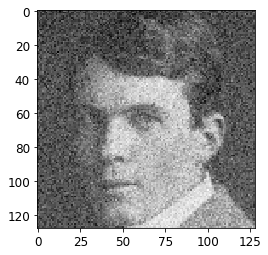

In [39]:
plt.imshow(xp_on.detach().numpy()[0,0,:,:], cmap='Greys')

torch.Size([1, 1, 128, 128])
[[0.9067888  0.7060856  0.8906555  ... 0.71476036 0.5309764  0.7972852 ]
 [0.9412917  0.80990773 0.95248824 ... 0.7426138  0.84741914 0.7919782 ]
 [0.6706371  0.8741736  0.78409827 ... 0.7531884  0.83891827 0.81805605]
 ...
 [0.75730467 0.86423415 0.7274576  ... 0.37932825 0.4536557  0.4630997 ]
 [0.72536373 1.0418731  0.86188316 ... 0.34291026 0.3613338  0.31205764]
 [0.66876787 0.8654497  0.67571336 ... 0.36349833 0.10719323 0.32579714]]


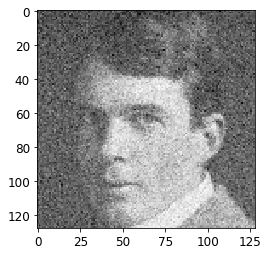

In [48]:
print(xp.shape)
plt.imshow(xp_on.detach().numpy()[0,0,:,:], cmap='Greys')
print(xp_on.detach().numpy()[0,0,:,:])

In [178]:
print(xp.grad)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
